In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
#export
from utils.nb_functions import *
from utils.nb_classes_l8_to_10 import *
from utils.nb_classes_l10_revised import *
from utils.nb_classes_cnn import *

Batchnorm paper:
    
https://arxiv.org/pdf/1502.03167.pdf

Activations: Things we calculate
    
Parameters: Things we learn

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

In [5]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [6]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [7]:
nfs = [8,16,32,64,64]

In [8]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [9]:
%time run.fit(2, learn)

train: [1.171886015625, tensor(0.6093, device='cuda:0')]
valid: [0.2135190673828125, tensor(0.9304, device='cuda:0')]
train: [0.163556923828125, tensor(0.9498, device='cuda:0')]
valid: [0.13449498291015624, tensor(0.9571, device='cuda:0')]
CPU times: user 3.92 s, sys: 828 ms, total: 4.74 s
Wall time: 4.74 s


## Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

In [8]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [9]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: 
        layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [36]:
#export
def init_cnn_(m, f):
    print(f'init_cnn_')
    if isinstance(m, nn.Conv2d):
        print(f'init_cnn_ nn.Conv2d model')
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: 
            m.bias.data.zero_()
    for l in m.children(): 
        init_cnn_(l, f)

def init_cnn(m, uniform=False):
    print(f'init_cnn uniform: {uniform}')
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    print(f'get_learn_run model: {model}')
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [11]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.25378279296875, tensor(0.9211, device='cuda:0')]
valid: [0.11315400390625, tensor(0.9657, device='cuda:0')]


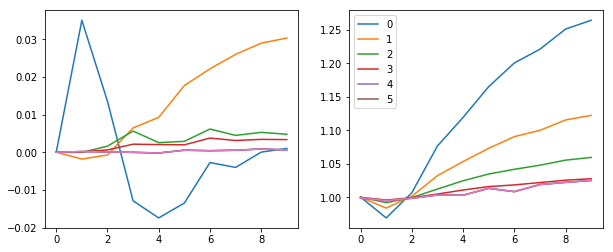

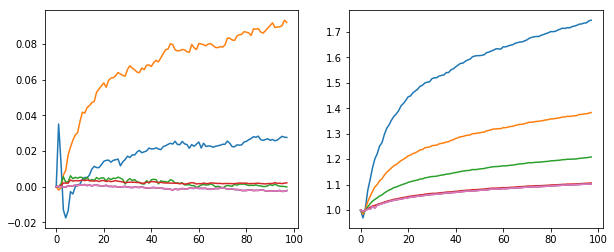

In [12]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [13]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [14]:
%time run.fit(3, learn)

train: [0.2617764453125, tensor(0.9182, device='cuda:0')]
valid: [0.16896717529296876, tensor(0.9449, device='cuda:0')]
train: [0.08557880859375, tensor(0.9742, device='cuda:0')]
valid: [0.09999280395507812, tensor(0.9693, device='cuda:0')]
train: [0.0632315234375, tensor(0.9810, device='cuda:0')]
valid: [0.13902763671875, tensor(0.9584, device='cuda:0')]
CPU times: user 3.2 s, sys: 62.1 ms, total: 3.26 s
Wall time: 3.27 s


### Builtin batchnorm

In [15]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [16]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [17]:
%time run.fit(3, learn)

train: [0.27576349609375, tensor(0.9181, device='cuda:0')]
valid: [0.10462418212890626, tensor(0.9689, device='cuda:0')]
train: [0.07443515625, tensor(0.9774, device='cuda:0')]
valid: [0.07187537231445312, tensor(0.9801, device='cuda:0')]
train: [0.0540714404296875, tensor(0.9835, device='cuda:0')]
valid: [0.06151331176757813, tensor(0.9820, device='cuda:0')]
CPU times: user 2.88 s, sys: 48.3 ms, total: 2.93 s
Wall time: 2.93 s


### With scheduler

Now let's add the usual warm-up/annealing.

In [18]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [19]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [20]:
run.fit(8, learn)

train: [0.3474255859375, tensor(0.8990, device='cuda:0')]
valid: [0.1405276611328125, tensor(0.9581, device='cuda:0')]
train: [0.088645576171875, tensor(0.9719, device='cuda:0')]
valid: [0.08338668212890625, tensor(0.9762, device='cuda:0')]
train: [0.0663630322265625, tensor(0.9786, device='cuda:0')]
valid: [0.06772711791992188, tensor(0.9807, device='cuda:0')]
train: [0.0415788427734375, tensor(0.9867, device='cuda:0')]
valid: [0.0678264404296875, tensor(0.9807, device='cuda:0')]
train: [0.02741280029296875, tensor(0.9916, device='cuda:0')]
valid: [0.058409295654296874, tensor(0.9833, device='cuda:0')]
train: [0.01870524169921875, tensor(0.9946, device='cuda:0')]
valid: [0.05565306396484375, tensor(0.9837, device='cuda:0')]
train: [0.011937703857421876, tensor(0.9970, device='cuda:0')]
valid: [0.04891856079101563, tensor(0.9852, device='cuda:0')]
train: [0.0085992529296875, tensor(0.9981, device='cuda:0')]
valid: [0.04865050659179687, tensor(0.9867, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In [21]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [22]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [23]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [24]:
%time run.fit(3, learn)

train: [nan, tensor(0.1290, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.53 s, sys: 28.2 ms, total: 4.55 s
Wall time: 4.56 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [25]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [26]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: 
        layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [27]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [28]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.58 s, sys: 24.8 ms, total: 4.6 s
Wall time: 4.61 s


*Question*: why can't this classify anything?

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

### Group norm

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectors of size `num_channels` if
`affine` is `True`.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    `num_groups (int)`: number of groups to separate the channels into
-    `num_channels (int)`: number of channels expected in input
-    `eps`: a value added to the denominator for numerical stability. Default: `1e-5`
-    `affine`: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

In [29]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [30]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: 
        layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [31]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [32]:
%time run.fit(1, learn)

train: [2.29603640625, tensor(0.1993, device='cuda:0')]
valid: [7044.3344, tensor(0.2946, device='cuda:0')]
CPU times: user 2min 15s, sys: 1.34 s, total: 2min 16s
Wall time: 2min 16s


### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

In [33]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

NB: the calculation of `self.dbias` in the version in the lesson video was incorrect. The correct version is in the cell above. Also, we changed how we calculated `self.mom1` to something that it more mathematically appropriate. These two changes improved the accuracy from 91% (in the video) to 97%+ (shown below)!

In [34]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [37]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

get_learn_run model: Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
init_cnn uniform: False
init_cnn_
init_cnn_
init_

In [38]:
%time run.fit(1, learn)

train: [0.3915116015625, tensor(0.8984, device='cuda:0')]
valid: [0.20024395751953125, tensor(0.9577, device='cuda:0')]
CPU times: user 5min 39s, sys: 1.86 s, total: 5min 41s
Wall time: 5min 42s


This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

In [39]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [40]:
learn,run = get_learn_run(nfs, data, 0.8, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

get_learn_run model: Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
init_cnn uniform: False
init_cnn_
init_cnn_
init_

In [41]:
%time run.fit(1, learn)

train: [0.154582412109375, tensor(0.9520, device='cuda:0')]
valid: [0.1290742431640625, tensor(0.9715, device='cuda:0')]
CPU times: user 22 s, sys: 112 ms, total: 22.2 s
Wall time: 22.2 s


### Simplified RunningBatchNorm

It turns out we don't actually need to debias - because, for instance, dividing a debiased sum by a debiased count is the same as dividing a *biased* sum by a *biased* count! So we can remove all the debiasing stuff and end up with a simpler class. Also, we should save `eps` as a buffer since it impacts the calculation. (Thanks to Stas Bekman for noticing these.) Also we can slightly change the final calculation in `forward` with one that uses `factor` and `offset` to reduce the amount of broadcasting required. (Thanks to Tom Viehmann for this suggestion.)

In [42]:
#export
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
        self.batch = 0
        
    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s    = x    .sum(dims, keepdim=True)
        ss   = (x*x).sum(dims, keepdim=True)
        c    = s.new_tensor(x.numel()/nc)
        mom1 = s.new_tensor(1 - (1-self.mom)/math.sqrt(bs-1))
        self.sums .lerp_(s , mom1)
        self.sqrs .lerp_(ss, mom1)
        self.count.lerp_(c , mom1)
        self.batch += bs
        means = self.sums/self.count
        varns = (self.sqrs/self.count).sub_(means*means)
        if bool(self.batch < 20): varns.clamp_min_(0.01)
        self.factor = self.mults / (varns+self.eps).sqrt()
        self.offset = self.adds - means*self.factor
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        return x*self.factor + self.offset

In [43]:
learn,run = get_learn_run(nfs, data, 0.8, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

get_learn_run model: Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
init_cnn uniform: False
init_cnn_
init_cnn_
init_

In [44]:
%time run.fit(1, learn)

train: [0.1703979296875, tensor(0.9470, device='cuda:0')]
valid: [0.08865293579101563, tensor(0.9756, device='cuda:0')]
CPU times: user 19.5 s, sys: 80.2 ms, total: 19.6 s
Wall time: 19.6 s


## Export

In [45]:
#nb_auto_export()